In [26]:
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np

import geopy.distance
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon # NOTE - HAVE TO DOWNLOAD MULTI FOR ACS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.decomposition import PCA 

In [11]:
def extractCentroid(point):
    return (point.centroid.x, point.centroid.y)

def fixPad(item):
    length = len(str(item))
    if length == 6:
        return str(item)
    else:
        return '0' + str(item)

def formatHourly(row):
    time = int(row['time'])
    if (row['timeOfDay'] == 'PM'):
        if (time == 12):
            return time
        else:
            return time+12
    else:
        if (time==12):
            return 0
        else:
            return time
    
def formatTime(item):
    if item!= 0:
        return int(item/100)
    else:
        return int(item)
    
def formatDate(time):
    year = time[:4]
    month = time[5:7]
    day = time[8:10]
    return month + '/' + day + '/' + year

def column_ot(df, column_name):
    
    percent_25 = np.percentile(df[column_name], 25)
    percent_75 = np.percentile(df[column_name], 75)
    
    iqr = percent_75 - percent_25
    lower_limit  = round(percent_25 - 1.5 * iqr, 2)
    upper_limit = round(percent_75 + 1.5 * iqr, 2)

    new_column = np.where(df[column_name] < lower_limit, lower_limit-1,
                           np.where(df[column_name] > upper_limit, upper_limit+1, df[column_name]))
#     if df[column_name].equals(new_column):
#         print("no change")
#     else:
#         print(column_name)
    
    return new_column

def outlier_treatment(df, columns_needing_ot):
    for col in columns_needing_ot:
        df[col] = column_ot(df, col)
    return df

# returns df with updated columns

columns_needing_ot = ['Area_x', 'accounting_x', 'airport_x',
       'amusement_park_x', 'aquarium_x', 'art_gallery_x', 'atm_x',
       'bakery_x', 'bank_x', 'bar_x', 'beauty_salon_x', 'bicycle_store_x',
       'book_store_x', 'bowling_alley_x', 'bus_station_x', 'cafe_x',
       'car_dealer_x', 'car_rental_x', 'car_repair_x', 'car_wash_x',
       'casino_x', 'cemetery_x', 'church_x', 'city_hall_x',
       'clothing_store_x', 'convenience_store_x', 'dentist_x',
       'department_store_x', 'doctor_x', 'drugstore_x', 'electrician_x',
       'electronics_store_x', 'embassy_x', 'finance_x', 'fire_station_x',
       'florist_x', 'food_x', 'funeral_home_x', 'furniture_store_x',
       'gas_station_x', 'general_contractor_x',
       'grocery_or_supermarket_x', 'gym_x', 'hair_care_x',
       'hardware_store_x', 'health_x', 'hindu_temple_x',
       'home_goods_store_x', 'hospital_x', 'insurance_agency_x',
       'jewelry_store_x', 'laundry_x', 'lawyer_x', 'library_x',
       'liquor_store_x', 'local_government_office_x', 'locality_x',
       'locksmith_x', 'lodging_x', 'meal_delivery_x', 'meal_takeaway_x',
       'mosque_x', 'movie_rental_x', 'movie_theater_x',
       'moving_company_x', 'museum_x', 'natural_feature_x',
       'neighborhood_x', 'night_club_x', 'painter_x', 'park_x',
       'parking_x', 'pet_store_x', 'pharmacy_x', 'physiotherapist_x',
       'place_of_worship_x', 'plumber_x', 'police_x', 'political_x',
       'post_office_x', 'premise_x', 'primary_school_x',
       'real_estate_agency_x', 'restaurant_x', 'roofing_contractor_x',
       'rv_park_x', 'school_x', 'secondary_school_x', 'shoe_store_x',
       'shopping_mall_x', 'spa_x', 'stadium_x', 'storage_x', 'store_x',
       'subway_station_x', 'supermarket_x', 'synagogue_x', 'taxi_stand_x',
       'tourist_attraction_x', 'train_station_x', 'transit_station_x',
       'travel_agency_x', 'university_x', 'veterinary_care_x', 'zoo_x',
       'tot_POIs_x', 'pub_trans_POIs_x', 'dens_tot_POIs_x',
       'dens_pub_trans_POIs_x', 'Area_y',
       'accounting_y', 'airport_y', 'amusement_park_y', 'aquarium_y',
       'art_gallery_y', 'atm_y', 'bakery_y', 'bank_y', 'bar_y',
       'beauty_salon_y', 'bicycle_store_y', 'book_store_y',
       'bowling_alley_y', 'bus_station_y', 'cafe_y', 'car_dealer_y',
       'car_rental_y', 'car_repair_y', 'car_wash_y', 'casino_y',
       'cemetery_y', 'church_y', 'city_hall_y', 'clothing_store_y',
       'convenience_store_y', 'dentist_y', 'department_store_y',
       'doctor_y', 'drugstore_y', 'electrician_y', 'electronics_store_y',
       'embassy_y', 'finance_y', 'fire_station_y', 'florist_y', 'food_y',
       'funeral_home_y', 'furniture_store_y', 'gas_station_y',
       'general_contractor_y', 'grocery_or_supermarket_y', 'gym_y',
       'hair_care_y', 'hardware_store_y', 'health_y', 'hindu_temple_y',
       'home_goods_store_y', 'hospital_y', 'insurance_agency_y',
       'jewelry_store_y', 'laundry_y', 'lawyer_y', 'library_y',
       'liquor_store_y', 'local_government_office_y', 'locality_y',
       'locksmith_y', 'lodging_y', 'meal_delivery_y', 'meal_takeaway_y',
       'mosque_y', 'movie_rental_y', 'movie_theater_y',
       'moving_company_y', 'museum_y', 'natural_feature_y',
       'neighborhood_y', 'night_club_y', 'painter_y', 'park_y',
       'parking_y', 'pet_store_y', 'pharmacy_y', 'physiotherapist_y',
       'place_of_worship_y', 'plumber_y', 'police_y', 'political_y',
       'post_office_y', 'premise_y', 'primary_school_y',
       'real_estate_agency_y', 'restaurant_y', 'roofing_contractor_y',
       'rv_park_y', 'school_y', 'secondary_school_y', 'shoe_store_y',
       'shopping_mall_y', 'spa_y', 'stadium_y', 'storage_y', 'store_y',
       'subway_station_y', 'supermarket_y', 'synagogue_y', 'taxi_stand_y',
       'tourist_attraction_y', 'train_station_y', 'transit_station_y',
       'travel_agency_y', 'university_y', 'veterinary_care_y', 'zoo_y',
       'tot_POIs_y', 'pub_trans_POIs_y', 'dens_tot_POIs_y',
       'dens_pub_trans_POIs_y']

## Import Master table

In [3]:
import_start = time.time()
start_time = time.time()
thirdMerge = pd.read_csv('../data/masterNoDemo.csv')
thirdMerge.drop(['Unnamed: 0'], axis=1, inplace=True)
newOrigin = thirdMerge['origin'].apply(lambda x: fixPad(x))
newDest = thirdMerge['dest'].apply(lambda x: fixPad(x))
thirdMerge['origin'] = newOrigin
thirdMerge['dest'] = newDest
thirdMerge.head()
print("Time: ", time.time() - start_time)

Time:  178.73468589782715


In [4]:
thirdMerge.head(2)

,origin,dest,date,hour,Trip ID,Area_x,accounting_x,airport_x,amusement_park_x,aquarium_x,...,dateReform,timeReform,temp,windspeedMiles,precipMM,humidity,visibility,WindChillF,uvIndex,day_of_week
0,010100,010100,09/01/2019,14,1,383167.215833,0.0,0.0,0.0,0.0,...,09/01/2019,14,70,5,0.0,74,28,70,5,6
1,010100,010100,09/01/2019,16,1,383167.215833,0.0,0.0,0.0,0.0,...,09/01/2019,16,71,4,0.0,76,28,71,5,6


## Calculating Distances

In [ ]:
Census Tract -> Centroid Location (df_census) 
    df_census = gpd.read_file('CensusTractBoundaries.geojson')
Centroid Location

Better to calculate distance for every single row?
Or to create the dictionary and search up for the pair?
Calculate distance for every single set pair
    Join
    Dictionary lookup
    
For each OD, merge by tractce10 of df_census, for O and D
- OR create lookup table, pull tractce10, get centroid
- Calculate distance
Calculate the distance between each

In [14]:
df_census = gpd.read_file('../data/CensusTractBoundaries.geojson')

In [15]:
df_census = df_census[['tractce10', 'geometry']]
df_census['Area(mi_squared)'] = df_census['geometry'].to_crs({'init': 'epsg:3395'})\
               .map(lambda p: 0.386102*(p.area / 10**6))
df_census['centroid'] = df_census['geometry'].apply(lambda x: extractCentroid(x))
fixedNames = df_census['tractce10'].apply(lambda x: fixPad(x))
df_census['tractce10'] = fixedNames
df_census.head(3)

,tractce10,geometry,Area(mi_squared),centroid
0,842400,(POLYGON ((-87.62404799998049 41.7302169999839...,1.361229,"(-87.63004035576937, 41.74247518248426)"
1,840300,(POLYGON ((-87.6860799999848 41.82295600001154...,0.576359,"(-87.6818820146571, 41.83209440350829)"
2,841100,(POLYGON ((-87.62934700001182 41.8527970000265...,0.793177,"(-87.63509777614824, 41.8510058477232)"


In [17]:
start_time = time.time()
tempSet = [(a,b) for (a,b) in zip(np.array(thirdMerge['origin']), np.array(thirdMerge['dest']))]
print("TIME: ", time.time() - start_time)

start_time = time.time()
tractLookup = {}
for index, row in df_census.iterrows():
    tractLookup[row['tractce10']] = row['centroid']
print("TIME: ", time.time() - start_time)

TIME:  1.6651561260223389


In [27]:
start_time = time.time()
origins = []
dests = []
distances = []
for item in tempSetFinal:
    o = item[0]
    d = item[1]
    distance = geopy.distance.geodesic(tractLookup[o], tractLookup[d]).km
    origins.append(o)
    dests.append(d)
    distances.append(distance)
print("TIME: ", time.time() - start_time)

TIME:  35.29343295097351


In [31]:
distTable = pd.DataFrame(columns=['origin', 'dest', 'distances'])
distTable['origin'] = origins
distTable['dest'] = dests
distTable['distances'] = distances

In [32]:
print(distTable.shape)
distTable.head()

(214059, 3)


,origin,dest,distances
0,071100,560800,13.538006
1,280400,160200,7.436610
2,410700,221100,12.986636
3,720500,240300,1.830697
4,080400,840200,0.969731


In [33]:
thirdMerge.head()

,origin,dest,date,hour,Trip ID,Area_x,accounting_x,airport_x,amusement_park_x,aquarium_x,...,dateReform,timeReform,temp,windspeedMiles,precipMM,humidity,visibility,WindChillF,uvIndex,day_of_week
0,010100,010100,09/01/2019,14,1,383167.215833,0.0,0.0,0.0,0.0,...,09/01/2019,14,70,5,0.0,74,28,70,5,6
1,010100,010100,09/01/2019,16,1,383167.215833,0.0,0.0,0.0,0.0,...,09/01/2019,16,71,4,0.0,76,28,71,5,6
2,010100,010100,09/02/2019,14,1,383167.215833,0.0,0.0,0.0,0.0,...,09/02/2019,14,77,3,0.0,59,28,77,7,0
3,010100,010100,09/03/2019,15,1,383167.215833,0.0,0.0,0.0,0.0,...,09/03/2019,15,80,15,0.4,69,28,80,6,1
4,010100,010100,09/03/2019,9,1,383167.215833,0.0,0.0,0.0,0.0,...,09/03/2019,9,72,16,0.3,77,28,72,6,1


In [34]:
start_time = time.time()
fourthMerge = thirdMerge.merge(distTable, how='left', left_on=['origin','dest'], right_on=['origin', 'dest'])
print("TIME: ", time.time() - start_time)
print(thirdMerge.shape)
print(fourthMerge.shape)

TIME:  62.17598915100098
(4317238, 235)
(4317238, 236)


In [37]:
thirdMerge = fourthMerge

## Filter to desired days + Delete unnecessary columns

In [38]:
start_time = time.time()
# weekdayDf = thirdMerge[(thirdMerge['day_of_week'] >= 0) & (thirdMerge['day_of_week'] <= 3)].reset_index()
# weekdayDfClean = weekdayDf.drop(columns = ['day_of_week', 'date', 'dateReform', 'timeReform', 'county_x', 'county_y'])
# weekdayDfClean.drop(columns=['index'],inplace=True)

weekdayDf = thirdMerge
weekdayDfClean = weekdayDf.drop(columns = ['date', 'dateReform', 'timeReform', 'county_x', 'county_y'])

weekdayDfClean['classification'] = weekdayDfClean['Trip ID'].apply(lambda x: x==1)
weekdayDfClean.head(3)
print("Time taken: ", time.time() - start_time)

Time taken:  47.11854887008667


In [39]:
weekdayTrips = weekdayDfClean['Trip ID']
weekdayBool = weekdayDfClean['classification']
X = weekdayDfClean.drop(["Trip ID", 'classification'], axis=1)

In [40]:
print(weekdayDfClean.shape)
weekdayDfClean.head(2)

(4317238, 232)


,origin,dest,hour,Trip ID,Area_x,accounting_x,airport_x,amusement_park_x,aquarium_x,art_gallery_x,...,temp,windspeedMiles,precipMM,humidity,visibility,WindChillF,uvIndex,day_of_week,distances,classification
0,010100,010100,14,1,383167.215833,0.0,0.0,0.0,0.0,0.0,...,70,5,0.0,74,28,70,5,6,0.0,True
1,010100,010100,16,1,383167.215833,0.0,0.0,0.0,0.0,0.0,...,71,4,0.0,76,28,71,5,6,0.0,True


In [59]:
x_va.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,origin,dest,hour,day_of_week
0,-2.366030,-2.161614,0.036136,0.905863,0.596834,0.471204,0.177363,-0.179004,-1.531986,0.285910,...,1.049609,0.225758,-0.080892,0.273723,-0.633755,-0.707638,081403,650301,22,6
1,18.346078,-3.097330,4.946752,2.662847,-9.003875,0.491095,-4.507710,-1.744133,0.474217,-0.218817,...,0.074140,-0.036222,0.544655,-0.410327,0.027993,-0.752455,831100,839100,9,6
2,-2.098460,-1.905495,-2.494868,-2.559146,1.436549,-0.632790,-2.739054,-0.575228,-0.909786,0.866299,...,-0.265822,0.616786,0.502443,-0.624334,-0.791235,0.261315,580502,660800,12,5
3,-2.511543,-2.854060,-0.513397,0.856073,0.928680,-1.210171,-0.265285,0.873126,0.293082,0.068920,...,-0.284176,-0.164877,-0.500359,-0.223400,-0.681115,0.291366,061500,841900,8,3
4,-3.892224,-2.081422,1.118920,-0.420695,0.044912,0.310166,0.786993,0.739086,-0.234605,-0.806952,...,-0.195746,0.162008,0.374282,-0.026906,0.247081,0.311636,071400,081201,4,5


## Train, Test, Validate Split

In [63]:
start_time = time.time()
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(X, weekdayBool, weekdayTrips, test_size=0.2)
x_train, x_val, y_train, y_val, z_train, z_val  = train_test_split(x_train, y_train, z_train, test_size=0.2)
print(len(x_train), 'train examples')
print(len(x_val), 'validation examples')
print(len(x_test), 'test examples')
print("Time taken: ", time.time() - start_time)

2763032 train examples
690758 validation examples
863448 test examples
Time taken:  75.37296676635742


In [64]:
x_train.head(2)

,origin,dest,hour,Area_x,accounting_x,airport_x,amusement_park_x,aquarium_x,art_gallery_x,atm_x,...,dens_pub_trans_POIs_y,temp,windspeedMiles,precipMM,humidity,visibility,WindChillF,uvIndex,day_of_week,distances
2807728,340400,231200,22,291720.819261,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,78,2,1.4,76,28,78,0,2,9.975243
3647224,833100,081402,12,926919.365599,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,73,2,0.0,55,28,73,6,5,5.375511


In [65]:
x_val.head(2)

,origin,dest,hour,Area_x,accounting_x,airport_x,amusement_park_x,aquarium_x,art_gallery_x,atm_x,...,dens_pub_trans_POIs_y,temp,windspeedMiles,precipMM,humidity,visibility,WindChillF,uvIndex,day_of_week,distances
1630318,140602,010702,19,386446.847872,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,71,8,0.0,78,28,71,0,0,5.397385
2932716,411200,841000,16,404425.321235,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,75,14,0.0,58,28,75,6,1,2.624143


## Data Parameters

In [66]:
## Choose Data Parameters
dataVersion = 1
outlierTreatment = True
Normalizing = True
usePCA = True
varExpl = 0.95

In [67]:
if dataVersion == 1:
    print("Weather + POI Data")
    x_tr = x_train
    x_va = x_val
    x_te = x_test
elif dataVersion == 2:
    print("Weather Only")
    x_tr = x_train[['origin', 'dest', 'hour', 'temp', 'windspeedMiles', 'precipMM', 'humidity', 'visibility', 'WindChillF', 'uvIndex']]
    x_va = x_val[['origin', 'dest', 'hour', 'temp', 'windspeedMiles', 'precipMM', 'humidity', 'visibility', 'WindChillF', 'uvIndex']]
    x_te = x_test[['origin', 'dest', 'hour', 'temp', 'windspeedMiles', 'precipMM', 'humidity', 'visibility', 'WindChillF', 'uvIndex']]

Weather + POI Data


In [68]:
x_tr = x_tr.drop(columns=['origin', 'dest','hour','day_of_week'])
x_te = x_te.drop(columns=['origin', 'dest','hour','day_of_week'])
x_va = x_va.drop(columns=['origin', 'dest','hour','day_of_week'])

In [70]:
if outlierTreatment:
    start_time = time.time()
    train_treated = outlier_treatment(x_tr, columns_needing_ot)
    test_treated = outlier_treatment(x_te, columns_needing_ot)
    val_treated = outlier_treatment(x_va, columns_needing_ot)
    
    x_tr = train_treated
    x_te = test_treated
    x_va = val_treated
    print("Time taken: ", time.time() - start_time)

Time taken:  37.97070097923279


In [71]:
print(x_tr.shape)
print(x_va.shape)

(2763032, 226)
(690758, 226)


In [72]:
if Normalizing:
    start_time = time.time()
    scaler = StandardScaler()
    
    train_scaled = scaler.fit_transform(x_tr)
    test_scaled = scaler.transform(x_te)
    val_scaled = scaler.transform(x_va)
    print("Time taken: ", time.time() - start_time)

    x_tr = train_scaled
    x_te = test_scaled
    x_va = val_scaled

/Users/frankwang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/frankwang/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/frankwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/Users/frankwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


Time taken:  104.74303913116455


In [73]:
print(x_tr.shape)
print(x_va.shape)

(2763032, 226)
(690758, 226)


In [74]:
if usePCA:
    start_time = time.time()
    pca = PCA(n_components=varExpl, svd_solver='full')
    train_pca = pca.fit(x_tr)
    print(pca.explained_variance_ratio_)
#     print(pca.singular_values_)
    print(pca.n_components_)
    print("Time taken: ", time.time() - start_time)
    
    start_time = time.time()
    train_pca = pca.transform(x_tr)
    test_pca = pca.transform(x_te)
    val_pca = pca.transform(x_va)
    print("Time taken: ", time.time() - start_time)
    
    x_tr = train_pca
    x_te = test_pca
    x_va = val_pca

[0.1524564  0.1497649  0.02481072 0.02260829 0.02255905 0.02115458
 0.01689909 0.01568844 0.01561701 0.01483749 0.01439003 0.01233833
 0.01116113 0.01037893 0.0103041  0.0100299  0.00982167 0.00960849
 0.00914806 0.00898274 0.00825129 0.00813131 0.00802447 0.00793898
 0.00725108 0.00710778 0.00685793 0.00679901 0.00660488 0.0065019
 0.00631079 0.00622611 0.00614388 0.00597296 0.00576087 0.00569995
 0.00554781 0.00552225 0.00537874 0.00534546 0.00523752 0.00516356
 0.00512683 0.00508554 0.00501157 0.00491691 0.00474699 0.00469999
 0.00464209 0.00460416 0.0045904  0.00454151 0.00452382 0.00446983
 0.00445291 0.00439098 0.00424825 0.00417829 0.00410795 0.00404029
 0.00402283 0.00397484 0.0039429  0.0039038  0.00383234 0.00375772
 0.0036321  0.00354236 0.00351419 0.00347553 0.00345345 0.00338279
 0.00334802 0.00330269 0.00327778 0.00323001 0.00310209 0.00303653
 0.00300131 0.00292172 0.00290225 0.00285395 0.00280668 0.00277311
 0.00276427 0.00267108 0.00261189 0.00255294 0.00249333 0.00246

In [49]:
x_train.head()

,origin,dest,hour,Area_x,accounting_x,airport_x,amusement_park_x,aquarium_x,art_gallery_x,atm_x,...,dens_pub_trans_POIs_y,temp,windspeedMiles,precipMM,humidity,visibility,WindChillF,uvIndex,day_of_week,distances
2057890,240500,080300,0,2.345902e+05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,68,15,0.0,54,28,68,0,3,5.343152
1384073,081500,070103,20,2.969674e+05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,75,14,2.0,78,28,75,0,5,1.835776
1356629,081403,281900,23,1.828514e+06,0.0,0.0,0.0,0.0,0.0,0.0,...,4.53451,72,12,1.0,84,28,72,0,0,3.647890
3376953,830900,241400,17,1.043160e+06,0.0,0.0,0.0,0.0,1.0,1.0,...,0.00000,77,8,0.0,57,28,77,0,5,1.128549
1044080,080201,320400,8,1.360101e+05,0.0,0.0,0.0,0.0,0.0,0.0,...,15.68061,64,12,0.0,44,28,64,5,3,1.530420


In [75]:
columnNames = x_train.columns[3:]
x_train.reset_index(inplace=True)
x_test.reset_index(inplace=True)
x_val.reset_index(inplace=True)

In [76]:
x_tr = pd.DataFrame(x_tr)
x_te = pd.DataFrame(x_te)
x_va = pd.DataFrame(x_va)
x_tr['origin'],x_te['origin'],x_va['origin'] = x_train['origin'], x_test['origin'], x_val['origin']
x_tr['dest'],x_te['dest'],x_va['dest'] = x_train['dest'], x_test['dest'], x_val['dest']
x_tr['hour'],x_te['hour'],x_va['hour'] = x_train['hour'], x_test['hour'], x_val['hour']
x_tr['day_of_week'],x_te['day_of_week'],x_va['day_of_week'] = x_train['day_of_week'], x_test['day_of_week'], x_val['day_of_week']

In [52]:
x_tr.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,origin,dest,hour,day_of_week
0,-3.805456,-2.044274,0.442297,0.082397,-0.172264,-0.617287,0.015787,0.057880,0.196577,-0.211241,...,0.273129,-0.362323,-0.342999,-0.115768,0.163814,-0.621354,240500,080300,0,3
1,-3.416524,-2.504615,0.894545,-0.497388,0.330881,-0.206289,0.511931,0.373354,-0.408841,-0.418126,...,-0.448259,0.176241,-0.565162,-0.039708,0.086679,0.250202,081500,070103,20,5
2,-2.638975,-2.149042,1.241585,-1.474472,0.477166,1.841115,1.458503,-0.777502,-0.665707,-0.352516,...,-0.174791,0.415415,-1.027592,0.016497,-0.774873,-0.311127,081403,281900,23,0
3,-0.282098,4.067836,0.174436,1.032007,-1.317587,-1.592767,0.168675,-0.025745,1.318747,-0.155409,...,-0.141156,0.533291,-0.594985,-0.653656,0.384718,0.400732,830900,241400,17,5
4,14.685661,-7.550235,1.100419,-5.872728,2.028987,3.898199,7.339281,-6.258814,3.267170,-2.900515,...,-0.042352,-0.015926,0.014922,0.061941,0.225942,-0.055843,080201,320400,8,3


In [53]:
print("Time till model: ", time.time() - import_start)

Time till model:  2918.0419130325317


## Model Parameters

In [58]:
# Version 1: Default MLPC
MLPC = MLPClassifier(verbose=1,alpha=0.1)

In [59]:
start_time = time.time()
MLPC.fit(x_tr, y_train)
print("Time: ", time.time()-start_time)

Iteration 1, loss = 9.01776481
Iteration 2, loss = 9.31483667
Iteration 3, loss = 9.09054121
Iteration 4, loss = 8.66123020
Iteration 5, loss = 8.37402846
Iteration 6, loss = 8.05438484
Iteration 7, loss = 7.74023010
Iteration 8, loss = 7.36103452
Iteration 9, loss = 7.09784838
Iteration 10, loss = 6.60962643
Iteration 11, loss = 6.12799719
Iteration 12, loss = 5.35558009
Iteration 13, loss = 4.63436902
Iteration 14, loss = 3.15697414
Iteration 15, loss = 1.03468268
Iteration 16, loss = 0.59306835
Iteration 17, loss = 0.59051690
Iteration 18, loss = 0.59177417
Iteration 19, loss = 0.59344702
Iteration 20, loss = 0.59580198
Iteration 21, loss = 0.58926703
Iteration 22, loss = 0.59138720
Iteration 23, loss = 0.59600604
Iteration 24, loss = 0.59011543
Iteration 25, loss = 0.58960747
Iteration 26, loss = 0.59736663
Iteration 27, loss = 0.59244914
Iteration 28, loss = 0.59219373
Iteration 29, loss = 0.59135030
Iteration 30, loss = 0.59290044
Iteration 31, loss = 0.59509317
Iteration 32, los

In [61]:
# valid_predict = MPLC.predict(validate_pca)
MLPC.score(x_va, y_val)

0.7277541483413873

In [66]:
MLPC.score(x_tr,y_train)

0.7279694914861645

In [ ]:
filename = 'MPLCassifier_DOW.sav'
joblib.dump(MLPR, filename)

In [30]:
type(z_train)
# x_tr_array = x_tr.to_numpy()

pandas.core.series.Series

In [20]:
start_time = time.time()
MLPR = MLPRegressor(verbose=1,alpha=0.1,max_iter=100)
MLPR.fit(x_tr.values, z_train)
print("Time: ", time.time()-start_time)

Iteration 1, loss = 2026569.96566964
Iteration 2, loss = 20935.20021851
Iteration 3, loss = 18253.94143406
Iteration 4, loss = 14375.56460862
Iteration 5, loss = 11911.37510714
Iteration 6, loss = 9613.99248559
Iteration 7, loss = 7497.02343436
Iteration 8, loss = 5678.02069776
Iteration 9, loss = 4047.75947226
Iteration 10, loss = 3182.49818781
Iteration 11, loss = 2374.43759553
Iteration 12, loss = 1734.22524324
Iteration 13, loss = 1094.55104037
Iteration 14, loss = 795.19284934
Iteration 15, loss = 509.33365026
Iteration 16, loss = 329.13818996
Iteration 17, loss = 216.40727977
Iteration 18, loss = 169.18177613
Iteration 19, loss = 95.76159822
Iteration 20, loss = 63.88451668
Iteration 21, loss = 48.45987669
Iteration 22, loss = 50.60618547
Iteration 23, loss = 22.31903109
Iteration 24, loss = 13.44231042
Iteration 25, loss = 4.54447893
Iteration 26, loss = 3.34874189
Iteration 27, loss = 3.52218269
Iteration 28, loss = 3.30297965
Iteration 29, loss = 3.41978911
Iteration 30, loss 

In [28]:
def cpc_loss_exp(y_pred, y_true):
    
    assert(len(y_pred) == len(y_true))
    y_pred_total = sum([np.exp(x) for x in y_true])
    y_true_total = sum([np.exp(x) for x in y_pred])
    numerator = 2*sum([np.exp(min(a,b)) for (a,b) in zip(y_pred,y_true)])
    return numerator / (y_pred_total + y_true_total)

def cpc_loss(y_pred, y_true):
    
    assert(len(y_pred) == len(y_true))
    y_pred_total = sum(y_true)
    y_true_total = sum(y_pred)
    numerator = 2*sum([min(a,b) for (a,b) in zip(y_pred,y_true)])
    return numerator / (y_pred_total + y_true_total)
    
#     return np.mean([(np.exp(min(a,b))*2)/(np.exp(a) + np.exp(b)) for (a, b) in zip(y_pred, y_true)])

In [27]:
MLPRPred = MLPR.predict(x_va)

In [29]:
cpc_loss(MLPRPred,z_val)

0.6836058039414795

In [25]:
z_train_log = z_train.apply(lambda x: np.log(x))

In [32]:
start_time = time.time()
MLPR_log = MLPRegressor(verbose=1,alpha=0.1,max_iter=100)
MLPR_log.fit(x_tr.values, z_train_log)
print("Time: ", time.time()-start_time)

Iteration 1, loss = 2035473.84177731
Iteration 2, loss = 21487.83297812
Iteration 3, loss = 17991.10307403
Iteration 4, loss = 14436.02849149
Iteration 5, loss = 10979.65718989
Iteration 6, loss = 8964.08851927
Iteration 7, loss = 7126.34678845
Iteration 8, loss = 5994.88136738
Iteration 9, loss = 4530.57643395
Iteration 10, loss = 3816.92531928
Iteration 11, loss = 3146.13722996
Iteration 12, loss = 2429.48961001
Iteration 13, loss = 1796.62761930
Iteration 14, loss = 1439.06244020
Iteration 15, loss = 1057.86350539
Iteration 16, loss = 832.05215513
Iteration 17, loss = 621.94054822
Iteration 18, loss = 511.78550090
Iteration 19, loss = 377.59999445
Iteration 20, loss = 238.23729050
Iteration 21, loss = 181.05253504
Iteration 22, loss = 122.72396538
Iteration 23, loss = 61.05303536
Iteration 24, loss = 33.97417067
Iteration 25, loss = 17.15768653
Iteration 26, loss = 6.48267972
Iteration 27, loss = 1.07333019
Iteration 28, loss = 0.27911341
Iteration 29, loss = 0.42121312
Iteration 30

In [34]:
MLPRPred_log = MLPR_log.predict(x_va)
z_val_log = z_val.apply(lambda x: np.log(x))
cpc_loss_exp(MLPRPred_log,z_val_log)

0.7019876086624077

In [33]:
from sklearn.externals import joblib
filename = 'MLPRegression_reg.sav'
joblib.dump(MLPR, filename)

filename = 'MLPRegression_log.sav'
joblib.dump(MLPR_log, filename)
 
# some time later...
 
# load the model from disk
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, Y_test)
# print(result)

['MLPRegression_log.sav']

In [45]:
validate_final = x_va[['origin', 'dest', 'hour', 'day_of_week']]
validate_final['pred'] = [np.exp(x) for x in MLPRPred_log]
validate_final['actual'] = z_val.reset_index()['Trip ID']

/Users/frankwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
validate_final.head(100)

,origin,dest,hour,day_of_week,pred,actual
0,250400,650500,5,6,1.353126,1
1,221100,610300,12,6,1.353126,1
2,062800,240600,17,0,1.353126,1
3,330100,832900,23,4,1.353126,1
4,060800,243500,21,2,1.353126,1
5,081000,839100,20,5,1.353126,5
6,835800,490902,23,4,1.353126,1
7,838200,842900,15,6,1.353126,1
8,050100,281900,8,0,1.353126,1
9,063301,062600,10,6,1.353126,1


In [48]:
validate_final.to_csv("validationTest.csv")

(array([     0., 502702.,  95643.,  36293.,  18220.,      0.,  10682.,
          6842.,   4527.,   3176.,   2403.,      0.,   1765.,   1389.,
          1058.]),
 array([ 0.        ,  0.83333333,  1.66666667,  2.5       ,  3.33333333,
         4.16666667,  5.        ,  5.83333333,  6.66666667,  7.5       ,
         8.33333333,  9.16666667, 10.        , 10.83333333, 11.66666667,
        12.5       ]),
 <a list of 15 Patch objects>)

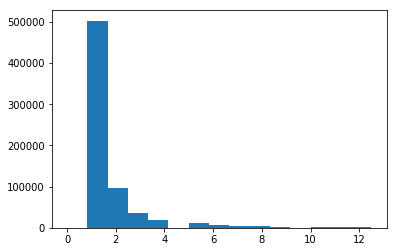

In [55]:
plt.hist(validate_final['actual'],15,(0,12.5))

In [67]:
print(len(z_val))
print(z_val.value_counts())

# print(sum(z_train))
print(len(z_train))
print(z_train.value_counts())

690758
1      502702
2       95643
3       36293
4       18220
5       10682
6        6842
7        4527
8        3176
9        2403
10       1765
11       1389
12       1058
13        910
14        720
15        577
16        496
17        388
18        335
19        298
20        238
21        208
22        206
23        176
24        151
25        127
26        124
27        102
28         84
29         81
30         78
        ...  
66          3
81          3
109         2
101         2
90          2
82          2
80          2
108         2
79          2
78          2
75          2
68          2
67          2
119         1
118         1
116         1
110         1
126         1
106         1
138         1
140         1
102         1
100         1
87          1
86          1
85          1
76          1
73          1
70          1
152         1
Name: Trip ID, Length: 99, dtype: int64
2763032
1      2011403
2       382310
3       144743
4        73544
5        42151
6        27257
7

In [68]:
# predict with model <- hopefully we're accurate
    # Check if it's because we're under predicting 1s?, if so we could include 2s
# for all predicted False ( != 1)
# train new regression model

# To test, classify validation set, set values to 1 if True
    # For false, set values by doing regression prediction

In [77]:
initial_save = time.time()
start_time = time.time()
x_train.to_csv('x_train.csv')
y_train.to_csv('y_train.csv')
z_train.to_csv('z_train.csv')
print("TIME: ", time.time()-start_time)

TIME:  423.66916608810425


In [78]:
start_time = time.time()
x_test.to_csv('x_test.csv')
y_test.to_csv('y_test.csv')
z_test.to_csv('z_test.csv')
print("TIME: ", time.time()-start_time)

start_time = time.time()
x_val.to_csv('x_val.csv')
y_val.to_csv('y_val.csv')
z_val.to_csv('z_val.csv')
print("TIME: ", time.time()-start_time)

TIME:  130.4433991909027
TIME:  98.45190072059631


In [79]:
start_time = time.time()
x_tr.to_csv('x_tr.csv')
x_te.to_csv('x_te.csv')
x_va.to_csv('x_va.csv')
print("TIME: ", time.time()-start_time)

TIME:  801.4103269577026


In [60]:
distanceSave = thirdMerge[['origin', 'dest', 'date', 'hour','day_of_week','distances','Trip ID']]
distanceSave.to_csv('baseDistTable.csv')